# 0. Setup

In [1]:
import keras as keras
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers as optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import models
from keras import regularizers
import tensorflow as tf
import math
import os

2022-12-30 09:58:33.846050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Hyperparameters

In [2]:
input_height = 69
input_width = 69
batch_size = 64

# TODO: find best parameters using the display_data_augmentation_sample jupyter notebook
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=False

rotation_range=40
width_shift_range=0.2
height_shift_range=0.1
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'

In [3]:
import keras.backend as K
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

metrics = [
    precision,
    recall,
    tf.keras.metrics.CategoricalAccuracy(name='acc')
]
optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=100
batch_size=32
#regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

2022-12-30 09:59:01.395916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
paths = {
    'TRAIN_PATH' : os.path.join('workspace', 'images', 'train'),
    'TEST_PATH' : os.path.join('workspace', 'images','test'),
    'EVAL_PATH' : os.path.join('workspace', 'images','eval'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'LOG_DIR' : os.path.join('model', 'log_dir')
 }

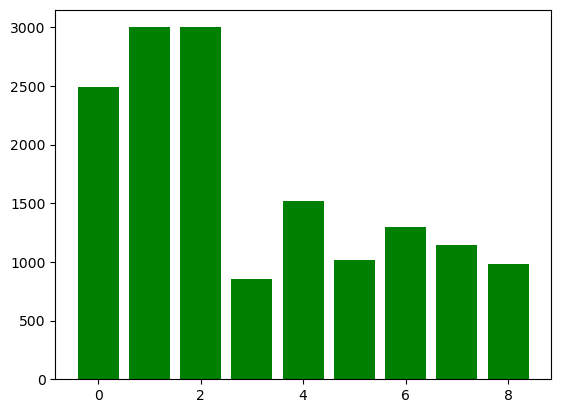

{0: 2488, 1: 3000, 2: 3000, 3: 858, 4: 1523, 5: 1016, 6: 1298, 7: 1146, 8: 981}


In [5]:
def plotTrainingDistribution():
    files_per_label = dict()
    for i in range(9):
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
      files_per_label[i] = n_images
    plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
    plt.show()
    print(files_per_label)
    return files_per_label

files_per_label = plotTrainingDistribution()

In [6]:
#weight computation

#number of classes
NUM_CLASSES = 9

#get number of total images
tot_images = sum(list(files_per_label.values()))
print(tot_images)

#dictionary storing weights for each class
#weight[i] = number_total_samples / number_total_classes * num_samples_class_i
weights = dict([ (class_label , tot_images/(NUM_CLASSES * n_images)) for class_label, n_images in files_per_label.items()])

print(weights)

15310
{0: 0.6837263308324402, 1: 0.567037037037037, 2: 0.567037037037037, 3: 1.9826469826469826, 4: 1.1169475450499744, 5: 1.6743219597550307, 6: 1.3105632597158021, 7: 1.4843901493116152, 8: 1.7340582172386454}


In [7]:
# training set image data generator
from keras.preprocessing.image import ImageDataGenerator
if augmentation:
    train_datagen = ImageDataGenerator(
          rescale=rescale_size,
          rotation_range=rotation_range,
          width_shift_range=width_shift_range,
          height_shift_range=height_shift_range,
          shear_range=shear_range,
          zoom_range=zoom_range,
          horizontal_flip=horizontal_flip,
          fill_mode=fill_mode)
else:
    train_datagen = ImageDataGenerator(rescale=1./255)
    # to perform normalization we should never use information coming from the test set, only training set

train_dir=paths['TRAIN_PATH']

# TODO: Consider if the output should be normalized
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 15310 images belonging to 9 classes.


In [8]:
# validation set image data generator
val_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

validation_dir=paths['EVAL_PATH']

validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 3919 images belonging to 9 classes.


# 3. Model creation

In [9]:
# Function used to create the CNN structure used for regression
def create_cnn(width, height, depth, num_classes,filters=(16, 32, 64)):
    inputShape = (height, width, depth)
    chanDim = -1
    model = models.Sequential()
    for (i, f) in enumerate(filters):
        # first CONV layer set appropriately
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same", input_shape=inputShape))
        else:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same"))
        # size of the patches typically 3x3 or 5x5
        # determine if we need to change padding or stride, with padding = same we are able to center convolutional windows around every input tile, in order to have always the same size of the input image
        # model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    # FLATTEN => FC => RELU => BN => DROPOUT
    model.add(Flatten())
    #model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu")) # consider if we need to add this dense layer before with more units, such as 64 in order to shrink in two different stages, depends on the outpout size of flatten
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dense(num_classes, activation="softmax"))
    return model

model = create_cnn(input_width, input_height, 3, 9, (16,32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9248)              0         
                                                                 
 dense (Dense)               (None, 64)                5

In [10]:
# compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# 4. Model training

In [11]:
n_images_eval = 0
for i in range(9):
    path = os.path.join(paths['EVAL_PATH'],str(i))
    #compute number of images in each eval folder and sum it up
    n_images_eval = n_images_eval + len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

print(n_images_eval)

3919


In [ ]:
# steps_per_epoch: number of batches to be drawn from the generator after assuming epoch over
# epochs: number of epochs
# validation_steps: how many batches to draw from the validation generator for evaluation

# TODO: set to the number of images we have
number_training = tot_images # TODO: contare elementi training cartella
number_eval = n_images_eval

history = model.fit(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=epochs,
      class_weight=weights,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

Epoch 1/100
479/479 [==============================] - 67s 126ms/step - loss: 1.9418 - precision: 0.1126 - recall: 0.0049 - acc: 0.2929 - val_loss: 1.7821 - val_precision: 0.3408 - val_recall: 0.0163 - val_acc: 0.3118
Epoch 2/100
479/479 [==============================] - 70s 145ms/step - loss: 1.6173 - precision: 0.5925 - recall: 0.0529 - acc: 0.3875 - val_loss: 1.4625 - val_precision: 0.5830 - val_recall: 0.0984 - val_acc: 0.4251
Epoch 3/100
479/479 [==============================] - 83s 173ms/step - loss: 1.4660 - precision: 0.6878 - recall: 0.1078 - acc: 0.4453 - val_loss: 1.3871 - val_precision: 0.7239 - val_recall: 0.1065 - val_acc: 0.4912
Epoch 4/100
479/479 [==============================] - 64s 134ms/step - loss: 1.3645 - precision: 0.7040 - recall: 0.1745 - acc: 0.4826 - val_loss: 1.3206 - val_precision: 0.6786 - val_recall: 0.2018 - val_acc: 0.4909
Epoch 5/100
479/479 [==============================] - 58s 121ms/step - loss: 1.2955 - precision: 0.7237 - recall: 0.2345 - acc:

# 5. Visualization

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

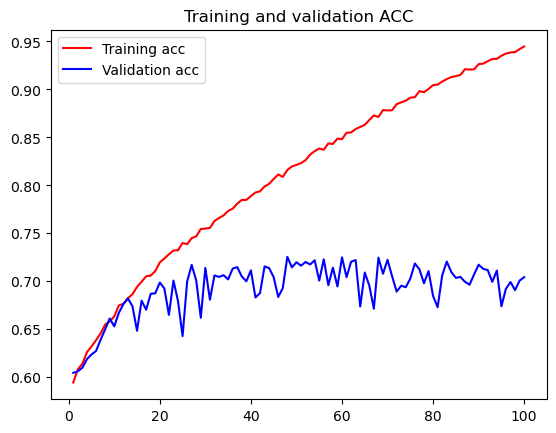

<Figure size 640x480 with 0 Axes>

In [53]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation ACC')
plt.legend()
plt.figure()

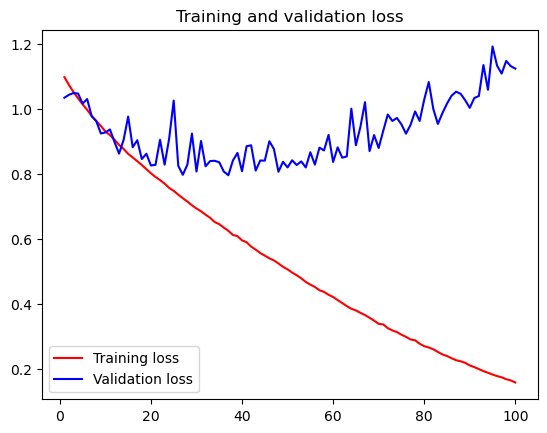

In [54]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

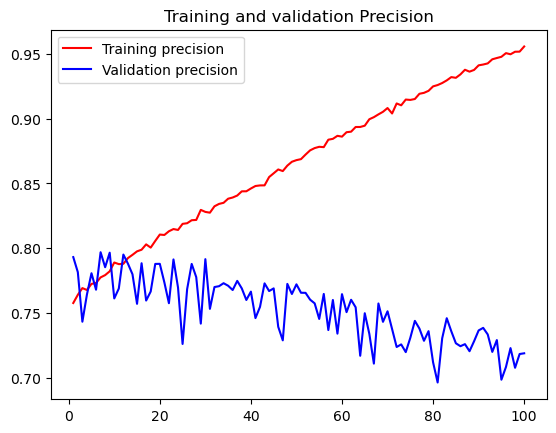

<Figure size 640x480 with 0 Axes>

In [55]:
precision = history.history['precision']
val_precision = history.history['val_precision']
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation Precision')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

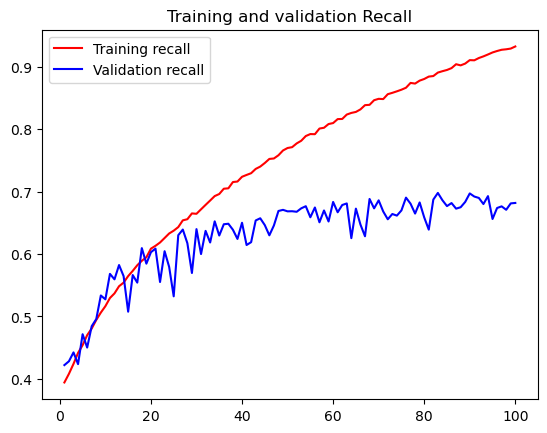

<Figure size 640x480 with 0 Axes>

In [56]:
recall = history.history['recall']
val_recall = history.history['val_recall']
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation Recall')
plt.legend()
plt.figure()

In [ ]:
# smooth curves if they look noisy
# replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# display average, the model may improve even if not reflected

# 6. Early stopping

In [62]:
import keras
import os

callbacks_list = [
        # interrupts training when accuracy has stopped improving accuracy on the validation set for at least 3+1=4 epochs
        keras.callbacks.EarlyStopping(
            monitor='acc', # should be part of the metrics specific during compilation
            patience=10,
        ),
        # save the current weights after every epoch
        #keras.callbacks.ModelCheckpoint(
        #    filepath=os.path.join(paths['MODELS'],'CNN_baseline.h5'),
        #    monitor='val_loss', # do not overwrite until val_loss is improved
        #    save_best_only=True
        #),
        # monitor the model's validation loss and reduce the LR when the validation loss has stopped improving, effective strategy to escape local minima
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # divides LR by 5 when triggered
            patience=3 # called when stopped improving for 3 epochs
        ),
        #keras.callbacks.TensorBoard(
        #    log_dir=paths['LOG_DIR'],
        #    write_graph=True,
        #    histogram_freq=1 # record activation histograms every 1 epoch
        #)
]

In [63]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=100,
      validation_data=validation_generator,
      callbacks=callbacks_list,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

Epoch 1/100


/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_29950/3927911465.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


479/479 [==============================] - 69s 140ms/step - loss: 1.8805 - precision: 0.0637 - recall: 0.0030 - acc: 0.3140 - val_loss: 1.6090 - val_precision: 0.2425 - val_recall: 0.0097 - val_acc: 0.3820 - lr: 1.0000e-04
Epoch 2/100
479/479 [==============================] - 78s 163ms/step - loss: 1.5806 - precision: 0.5174 - recall: 0.0536 - acc: 0.3912 - val_loss: 1.3762 - val_precision: 0.5631 - val_recall: 0.1581 - val_acc: 0.4236 - lr: 1.0000e-04
Epoch 3/100
479/479 [==============================] - 65s 136ms/step - loss: 1.4240 - precision: 0.6575 - recall: 0.1326 - acc: 0.4416 - val_loss: 1.3295 - val_precision: 0.5589 - val_recall: 0.2618 - val_acc: 0.4478 - lr: 1.0000e-04
Epoch 4/100
479/479 [==============================] - 66s 138ms/step - loss: 1.3176 - precision: 0.6691 - recall: 0.2012 - acc: 0.4800 - val_loss: 1.2871 - val_precision: 0.5881 - val_recall: 0.3195 - val_acc: 0.4575 - lr: 1.0000e-04
Epoch 5/100
479/479 [==============================] - 69s 143ms/step - 

# 7. Model testing

In [71]:
# check errors test set
import os
from PIL import Image
folder_path = paths['TEST_PATH']
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

* Path: workspace/images/test/9/11049.jpg  **** Path: workspace/images/test/9/21200.jpg  **** Path: workspace/images/test/9/5154.jpg  **** Path: workspace/images/test/9/10423.jpg  **** Path: workspace/images/test/9/17164.jpg  **** Path: workspace/images/test/9/14900.jpg  **** Path: workspace/images/test/9/8648.jpg  **** Path: workspace/images/test/9/928.jpg  **** Path: workspace/images/test/9/4446.jpg  **** Path: workspace/images/test/9/3063.jpg  **** Path: workspace/images/test/9/20895.jpg  **** Path: workspace/images/test/9/7986.jpg  **** Path: workspace/images/test/9/16489.jpg  **** Path: workspace/images/test/9/1289.jpg  **** Path: workspace/images/test/9/20689.jpg  **** Path: workspace/images/test/9/17742.jpg  **** Path: workspace/images/test/9/16716.jpg  **** Path: workspace/images/test/9/6568.jpg  **** Path: workspace/images/test/9/948.jpg  **** Path: workspace/images/test/9/15524.jpg  **** Path: workspace/images/test/9/813.jpg  **** Path: workspace/images/test/9/1015.jpg  **** 

In [93]:
from PIL import Image

number_test = 0
for i in range(9):
      path = os.path.join(paths['TEST_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_test += n_images

In [94]:
test_dir=paths['TEST_PATH']
print(test_dir)
test_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical', classes=None, shuffle=False)

workspace/images/test
Found 2931 images belonging to 9 classes.


In [95]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_generator.reset()
Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0','1','2','3','4','5','6','7','8']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_29950/2558299678.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, number_test // batch_size+1)


Confusion Matrix
[[  0 123 146   0  59   0  11 132   0]
 [  0 313 441   0  73   0   2 117   0]
 [  0 286 337   0  79   0   5 128   0]
 [  0  12  16   0  12   0   1   8   0]
 [  1  35  50   0  72   0   0  49   0]
 [  0  13   8   0  32   1   1  24   0]
 [  2  43  22   0   6   0   5  65   0]
 [  0  37  24   0   8   0   6  54   0]
 [  0  17  18   0  16   0   2  19   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       471
           1       0.36      0.33      0.34       946
           2       0.32      0.40      0.36       835
           3       0.00      0.00      0.00        49
           4       0.20      0.35      0.26       207
           5       1.00      0.01      0.02        79
           6       0.15      0.03      0.06       143
           7       0.09      0.42      0.15       129
           8       0.00      0.00      0.00        72

    accuracy                           0.27      2931
   macro avg 

/Users/francoterranova/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francoterranova/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/francoterranova/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_29950/2081199222.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, verbose = True)


92/92 [==============================] - 4s 41ms/step
Multiclass roc auc score: 0.783196983839097


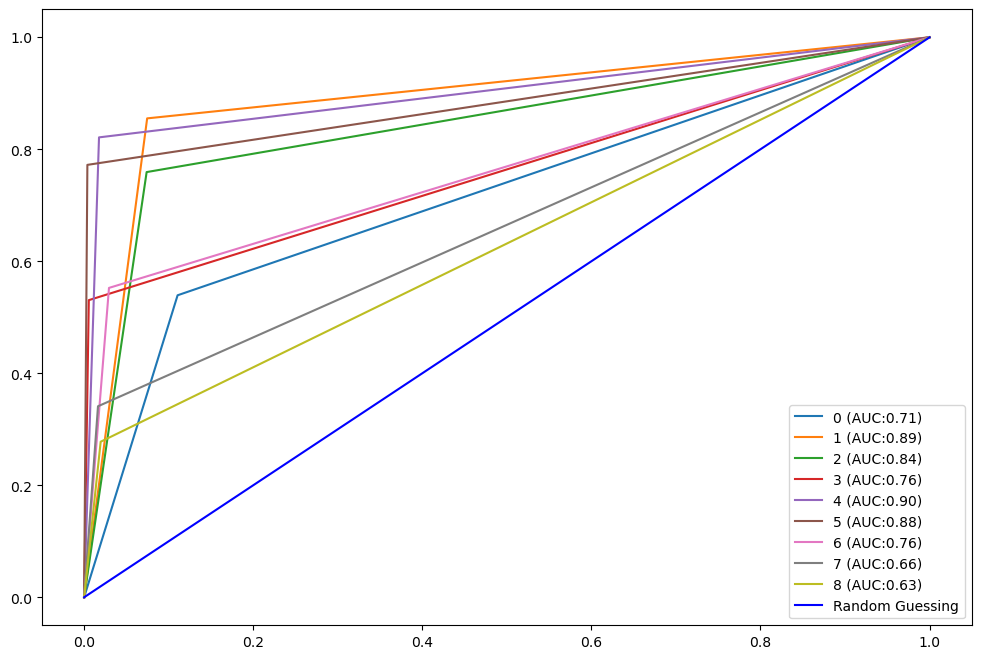

In [75]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    return roc_auc_score(y_test, y_pred, average=average)


test_generator.reset()
y_pred = model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
print("Multiclass roc auc score:", multiclass_roc_auc_score(test_generator.classes, y_pred))

# 8. Model exportation

In [64]:
model.save("models/CNN_baseline_class_weights.h5")

# 9. Plot model as graph of layers

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')